# Installing Dependencies

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# drive.flush_and_unmount()

Mounted at /content/drive


In [3]:
!pip install torch torchvision transformers
!pip install pillow imbalanced-learn

## Loading Libraries

In [4]:
import os
import pandas as pd
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from wordcloud import WordCloud
from collections import Counter
from imblearn.over_sampling import SMOTE

In [31]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

- The Final Data is the combined Data Combines locally due to colab constraints

In [5]:
review_file_path = r"/content/drive/MyDrive/project/final_selected_data.json"

data = []
with open(review_file_path, 'r', encoding='utf-8') as file:  # Specify UTF-8 encoding
    for line in file:
        data.append(json.loads(line))

print(data[:5])


[{'business_id': 'LHSTtnW3YHCeUkRDGyJOyw', 'stars': 5.0, 'text': 'Amazingly amazing wings and homemade bleu cheese. Had the ribeye: tender, perfectly prepared, delicious. Nice selection of craft beers. Would DEFINITELY recommend checking out this hidden gem.', 'photo_id': 'FVLHVFFRfTf_GGBPpY_TSA'}, {'business_id': 'gebiRewfieSdtt17PTW6Zg', 'stars': 3.0, 'text': "Had a party of 6 here for hibachi. Our waitress brought our separate sushi orders on one plate so we couldn't really tell who's was who's and forgot several items on an order. I understand making mistakes but the restaraunt was really quiet so we were kind of surprised. Usually hibachi is a fun lively experience and our  cook  said maybe three words, but he cooked very well his name was Francisco. Service was fishy, food was pretty good, and im hoping it was just an off night here. But for the money I wouldn't go back.", 'photo_id': 'NML2x1GKH-ZrDLMWgljdTw'}, {'business_id': 'EQ-TZ2eeD_E0BHuvoaeG5Q', 'stars': 4.0, 'text': "Loca

In [6]:
df = pd.DataFrame(data)
df.head()

,business_id,stars,text,photo_id
0,LHSTtnW3YHCeUkRDGyJOyw,5.0,Amazingly amazing wings and homemade bleu chee...,FVLHVFFRfTf_GGBPpY_TSA
1,gebiRewfieSdtt17PTW6Zg,3.0,Had a party of 6 here for hibachi. Our waitres...,NML2x1GKH-ZrDLMWgljdTw
2,EQ-TZ2eeD_E0BHuvoaeG5Q,4.0,"Locals recommended Milktooth, and it's an amaz...",-p4CqyODZVPduIBZtWtgcA
3,EQ-TZ2eeD_E0BHuvoaeG5Q,4.0,"Locals recommended Milktooth, and it's an amaz...",sAn9ohAfLWIASPhObEaqGw
4,EQ-TZ2eeD_E0BHuvoaeG5Q,4.0,"Locals recommended Milktooth, and it's an amaz...",AsMp1iXAVmWlkNVqMYE-Fw


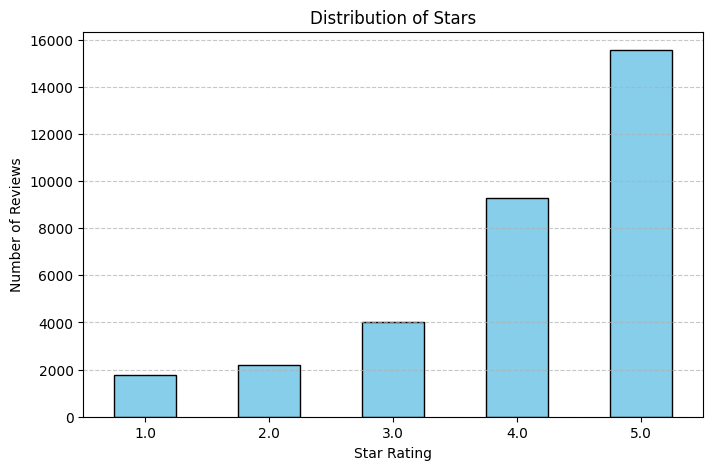

In [7]:
plt.figure(figsize=(8, 5))
df['stars'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Stars')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- As seen from the Bar chart the Data is imbalaned with high records of positive reviews

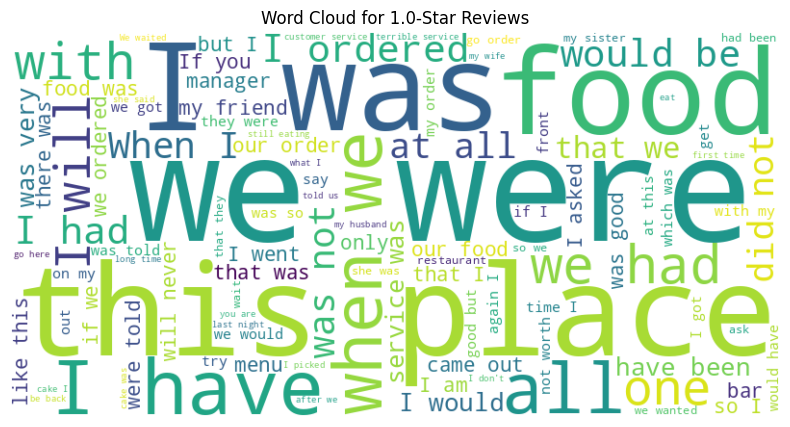

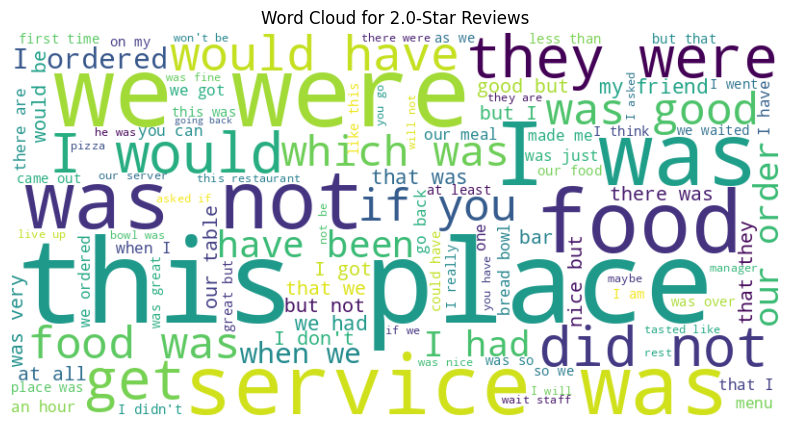

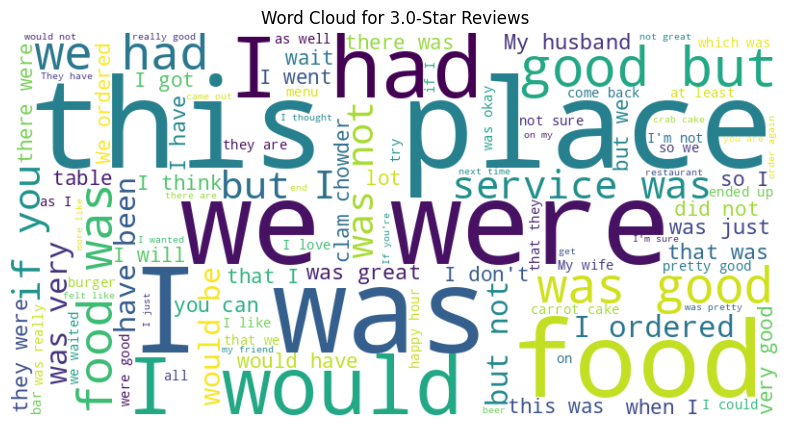

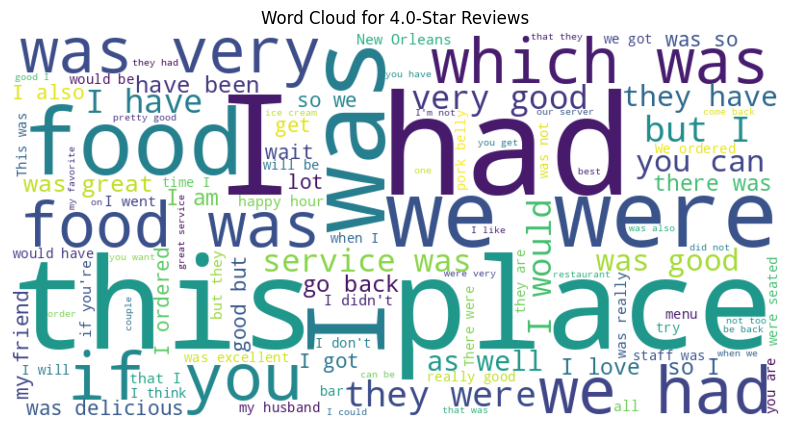

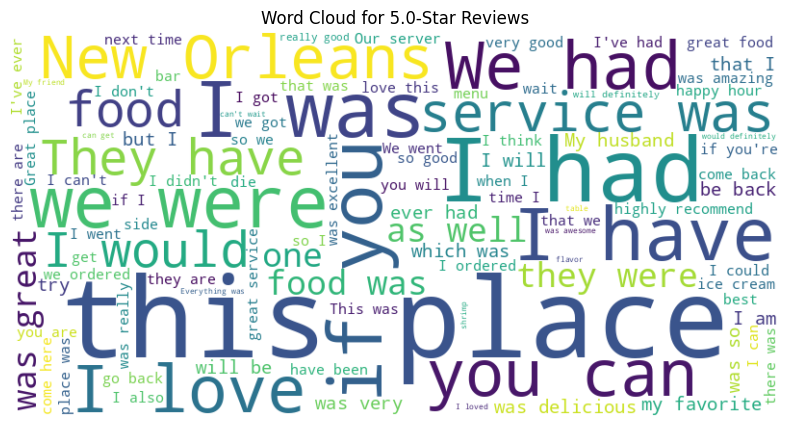

In [15]:
for star in sorted(df['stars'].unique()):
    text = ' '.join(df[df['stars'] == star]['text'].astype(str))
    wordcloud = WordCloud(
        width=800, height=400, background_color='white', colormap='viridis',
        max_words=100, stopwords={'the', 'and', 'to', 'a', 'of', 'is', 'in', 'for', 'it'}  # Add more stopwords if needed
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {star}-Star Reviews')
    plt.axis('off')
    plt.show()

- From this it is Clear that food is the main reason for a positive or negative sentiment while the Place comes in the middle

- This Dataset is Created by combining the train.json from kaggle [Yelp Photos Resource](https://www.kaggle.com/datasets/joshiatri/yelp-dataset-photos) to the yelp Review Resource on the [original site](https://www.yelp.com/dataset). The Resource  used for images is the subset of Main Data and the corresponding images is extracted


- Sample Review with Image

TVs lots and lots of TVs. That is the good thing I can say about this place. The atmosphere feels big and open, the booths have a big huge Texas kinda feel to then. And boy does this place get crowded. The parking lot is not small, yet it seemed to be overflowing on my last visit for a Thursday happy hour. 

While the booths felt big and open they also were not very private. There was a family nearby so I had to be careful to watch my language. I snacked on stuffed olives and deviled eggs. Did not get a full meal. Drank a tall Budweiser, and overall had fun with friends. I do prefer sports bars with a less corporate feel, something more like Ferg's is downtown St. Pete. The menu did look fascinating, and while the food was not too expensive, it did seem a bit pricy for being bar food.

Overall this is a decent sport bar and everything was A-OK. My snacks were good, service was a tad bit slow, but understandable with how crowded it was. Not going to be chompin' at the bit to come back, 

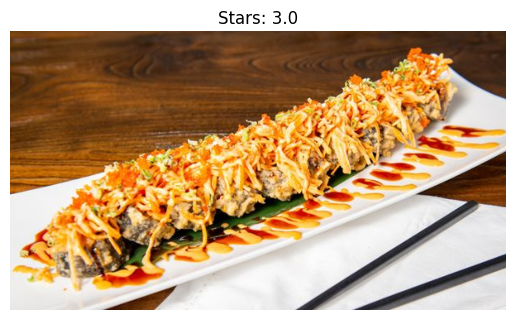

In [20]:
from PIL import Image
# Define the image directory
image_dir = r"/content/drive/MyDrive/project/Dataset"
import os
import matplotlib.pyplot as plt
# Randomly select a row from the DataFrame
random_row = df.sample(1).iloc[0]
photo_id = random_row["photo_id"]
image_path = os.path.join(image_dir, f"{photo_id}.jpg")
print(random_row['text'])

print(f"Checking photo_id: {photo_id}")
print(f"Image path: {image_path}")

# SKz3vEOcPaNhExLdXDb6DA.jpg

# Check if the image exists and display it
if os.path.exists("/content/drive/MyDrive/project/Dataset/SKz3vEOcPaNhExLdXDb6DA.jpg"):
    image = Image.open("/content/drive/MyDrive/project/Dataset/SKz3vEOcPaNhExLdXDb6DA.jpg")
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Stars: {random_row['stars']}")
    plt.show()
else:
    print(f"Image with ID {photo_id} not found in the directory: {image_dir}")

# Baseline Model

In [21]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split, cross_val_score

In [22]:
# Step 1: Prepare the Data
texts = df['text'].astype(str).values
labels = df['stars'].values - 1  # Adjust labels to start from 0

X_train_texts, X_temp_texts, y_train, y_temp = train_test_split(
    texts, labels, test_size=0.3, random_state=42
)
X_val_texts, X_test_texts, y_val, y_test = train_test_split(
    X_temp_texts, y_temp, test_size=0.5, random_state=42
)

In [23]:
# Step 2: Feature Extraction
# Option 1: Bag-of-Words
vectorizer_bow = CountVectorizer(max_features=5000, stop_words='english')
X_train_bow = vectorizer_bow.fit_transform(X_train_texts)
X_val_bow = vectorizer_bow.transform(X_val_texts)
X_test_bow = vectorizer_bow.transform(X_test_texts)


In [24]:
# Step 3: Train the Model
# Using Bag-of-Words
baseline_model_bow = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
baseline_model_bow.fit(X_train_bow, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [25]:
# Step 4: Cross-Validation (Optional)
cv_scores = cross_val_score(baseline_model_bow, X_train_bow, y_train, cv=5)
print("Cross-Validation Scores (Bag-of-Words):", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores (Bag-of-Words): [0.95053389 0.95380257 0.95118762 0.94966224 0.94857267]
Mean CV Score: 0.9507517977772935


In [26]:
# Step 5: Evaluate the Model
# Bag-of-Words
print("Baseline Model (Bag-of-Words) - Validation Set")
print(classification_report(y_val, baseline_model_bow.predict(X_val_bow)))

print("Baseline Model (Bag-of-Words) - Test Set")
print(classification_report(y_test, baseline_model_bow.predict(X_test_bow)))


Baseline Model (Bag-of-Words) - Validation Set
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       258
         1.0       0.93      0.94      0.94       339
         2.0       0.95      0.97      0.96       589
         3.0       0.94      0.94      0.94      1376
         4.0       0.98      0.97      0.97      2355

    accuracy                           0.96      4917
   macro avg       0.95      0.96      0.95      4917
weighted avg       0.96      0.96      0.96      4917

Baseline Model (Bag-of-Words) - Test Set
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       243
         1.0       0.95      0.93      0.94       310
         2.0       0.93      0.95      0.94       560
         3.0       0.94      0.95      0.94      1405
         4.0       0.98      0.97      0.97      2399

    accuracy                           0.96      4917
   macro avg       0.94      0.95      0.95

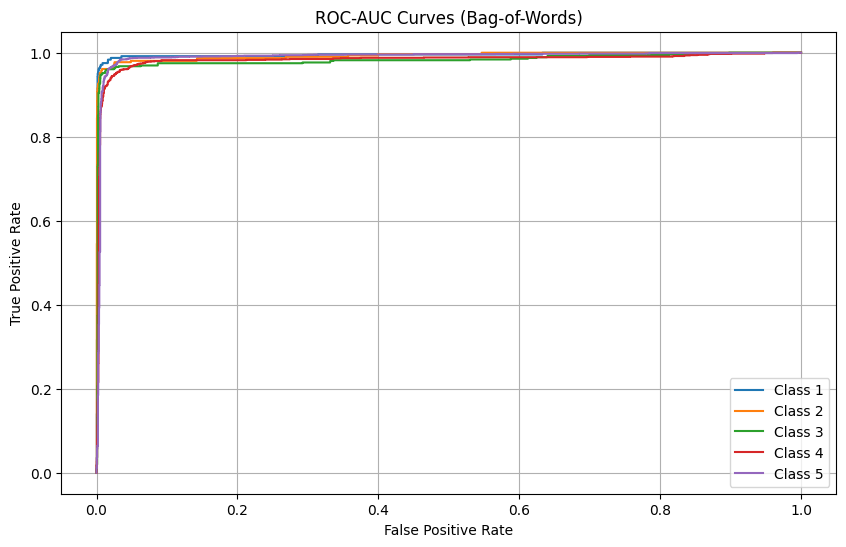

In [27]:
# Step 6: Additional Metrics and Visualization
# ROC-AUC
y_test_probs = baseline_model_bow.predict_proba(X_test_bow)
y_test_onehot = pd.get_dummies(y_test).values  # One-hot encoding for multi-class ROC-AUC

# ROC-AUC Curves
plt.figure(figsize=(10, 6))
for i in range(5):  # Assuming 5 classes
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_test_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i+1}")
plt.title("ROC-AUC Curves (Bag-of-Words)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

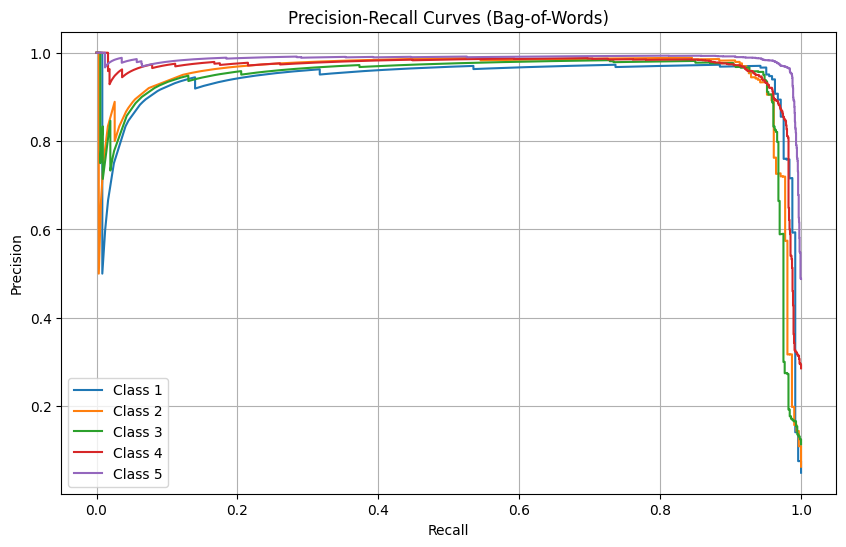

In [28]:
# Precision-Recall Curves
plt.figure(figsize=(10, 6))
for i in range(5):
    precision, recall, _ = precision_recall_curve(y_test_onehot[:, i], y_test_probs[:, i])
    plt.plot(recall, precision, label=f"Class {i+1}")
plt.title("Precision-Recall Curves (Bag-of-Words)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

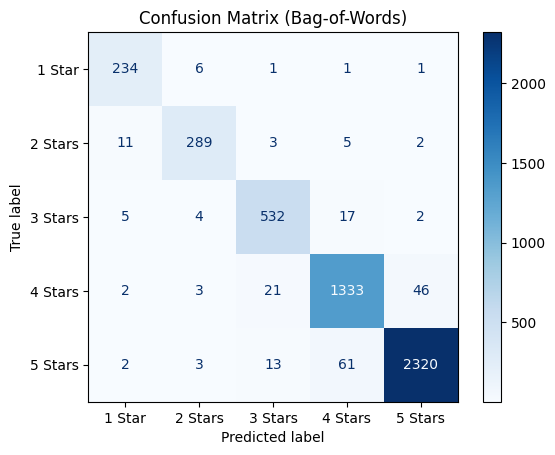

In [29]:
# Confusion Matrix
cm = confusion_matrix(y_test, baseline_model_bow.predict(X_test_bow))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"])
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix (Bag-of-Words)")
plt.show()

## Pre-processing (Encoding)

In [32]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [33]:
def load_and_process_data(row):
    # Load image
    image_path = os.path.join(image_dir, f"{row['photo_id']}.jpg")
    image = Image.open(image_path)

    # Process text and image for CLIP
    inputs = processor(
        text=row['text'],
        images=image,
        return_tensors="pt",
        padding=True,
        truncation=True,  # Enable truncation
        max_length=77     # Set the max length to avoid exceeding limits
    ).to(device)

    return inputs

- Selecting the Top 1000 records only for faster computation

In [34]:
# Initialize lists to hold embeddings and labels
limit = 1500  # limit for records
features = []
labels = []
count = 0

# Load and process each review
for index, row in df.iterrows():
    try:
      inputs = load_and_process_data(row)
    except:
      continue
    with torch.no_grad():
        outputs = model(**inputs)
        text_embeds = outputs.text_embeds.cpu().numpy()
        image_embeds = outputs.image_embeds.cpu().numpy()

        # Concatenate text and image embeddings
        combined_embeds = np.concatenate((text_embeds, image_embeds), axis=1)

        features.append(combined_embeds)
        labels.append(row['stars'])
        count+=1
        if count > limit:
          break

# Convert to numpy arrays
X = np.array(features)
y = np.array(labels)

In [35]:
X = X.reshape(X.shape[0], -1)
print(X.shape)  # Should now be (1001, 1024)

(932, 1024)


In [36]:
y.shape

(932,)

## Modeling

In [37]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# SMOTE: Handle Class Imbalance
def apply_smote(X, y):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X, y)

X_train, y_train = apply_smote(X_train, y_train)
y_train = y_train - 1  # Ensure labels start from 0
y_val = y_val - 1
y_test = y_test - 1

# Verify label ranges
print("Unique labels in y_train:", np.unique(y_train))
print("Unique labels in y_val:", np.unique(y_val))
print("Unique labels in y_test:", np.unique(y_test))

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

Unique labels in y_train: [0. 1. 2. 3. 4.]
Unique labels in y_val: [0. 1. 2. 3. 4.]
Unique labels in y_test: [0. 1. 2. 3. 4.]


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Recompute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    # def forward(self, inputs, targets):
    #   # Ensure `inputs` has shape (batch_size, num_classes) and `targets` has shape (batch_size)
    #   ce_loss = nn.CrossEntropyLoss(reduction="none")(inputs, targets)
    #   pt = torch.exp(-ce_loss)
    #   focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
    #   return focal_loss.mean()

    def forward(self, inputs, targets):
      # Calculate Cross-Entropy Loss
      ce_loss = nn.CrossEntropyLoss(reduction="none")(inputs, targets)
      pt = torch.exp(-ce_loss)

      # Apply class weights using `self.alpha`
      alpha_t = self.alpha.gather(0, targets)  # Align alpha with batch labels

      # Compute Focal Loss
      focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
      return focal_loss.mean()

class AttentionFusion(nn.Module):
    def __init__(self, embed_dim):
        super(AttentionFusion, self).__init__()
        self.text_fc = nn.Linear(embed_dim, embed_dim)
        self.image_fc = nn.Linear(embed_dim, embed_dim)
        self.attention_fc = nn.Linear(embed_dim * 2, 1)

    def forward(self, text_features, image_features):
        # Project text and image features
        text_proj = torch.relu(self.text_fc(text_features))
        image_proj = torch.relu(self.image_fc(image_features))

        # Concatenate features
        combined_features = torch.cat((text_proj, image_proj), dim=1)

        # Compute attention scores
        attention_scores = torch.sigmoid(self.attention_fc(combined_features))

        # Weighted sum of features
        fused_features = attention_scores * text_proj + (1 - attention_scores) * image_proj
        return fused_features


# Define the model
class SentimentModelWithAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_classes):
        super(SentimentModelWithAttention, self).__init__()
        self.attention_fusion = AttentionFusion(embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, text_features, image_features):
        # Fuse features using attention
        fused_features = self.attention_fusion(text_features, image_features)

        # Pass through dense layers
        x = torch.relu(self.fc1(fused_features))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits


# Initialize model and move it to the device
input_size = X.shape[1]
model = SentimentModelWithAttention(embed_dim=512, hidden_dim=256, num_classes=5).to(device)

# Define loss function, optimizer, and scheduler
# criterion = FocalLoss(alpha=1, gamma=2)
criterion = FocalLoss(alpha=class_weights_tensor, gamma=2)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [39]:
# Training loop with validation
num_epochs = 20
batch_size = 8

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Skip incomplete batch
        if X_batch.shape[0] != batch_size:
            continue

        # Split combined embeddings into text and image features
        text_features = X_batch[:, :512]  # First 512 dimensions for text
        image_features = X_batch[:, 512:]  # Remaining 512 dimensions for image

        # Forward pass
        outputs = model(text_features, image_features)
        loss = criterion(outputs, y_batch)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_loss = epoch_loss / len(X_train_tensor)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        text_val_features = X_val_tensor[:, :512]
        image_val_features = X_val_tensor[:, 512:]
        val_outputs = model(text_val_features, image_val_features)
        val_loss = criterion(val_outputs, y_val_tensor).item()

    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch [1/20], Train Loss: 0.1189, Val Loss: 0.8802
Epoch [2/20], Train Loss: 0.0980, Val Loss: 1.0337
Epoch [3/20], Train Loss: 0.0935, Val Loss: 0.7523
Epoch [4/20], Train Loss: 0.0705, Val Loss: 1.7046
Epoch [5/20], Train Loss: 0.0777, Val Loss: 1.1073
Epoch [6/20], Train Loss: 0.0699, Val Loss: 1.1412
Epoch [7/20], Train Loss: 0.0651, Val Loss: 1.1279
Epoch [8/20], Train Loss: 0.0570, Val Loss: 0.7300
Epoch [9/20], Train Loss: 0.0457, Val Loss: 0.7269
Epoch [10/20], Train Loss: 0.0410, Val Loss: 0.7288
Epoch [11/20], Train Loss: 0.0366, Val Loss: 0.7455
Epoch [12/20], Train Loss: 0.0328, Val Loss: 0.7695
Epoch [13/20], Train Loss: 0.0301, Val Loss: 0.7915
Epoch [14/20], Train Loss: 0.0272, Val Loss: 0.8519
Epoch [15/20], Train Loss: 0.0236, Val Loss: 0.8901
Epoch [16/20], Train Loss: 0.0216, Val Loss: 0.9195
Epoch [17/20], Train Loss: 0.0198, Val Loss: 0.9483
Epoch [18/20], Train Loss: 0.0188, Val Loss: 0.9870
Epoch [19/20], Train Loss: 0.0175, Val Loss: 1.0030
Epoch [20/20], Train 

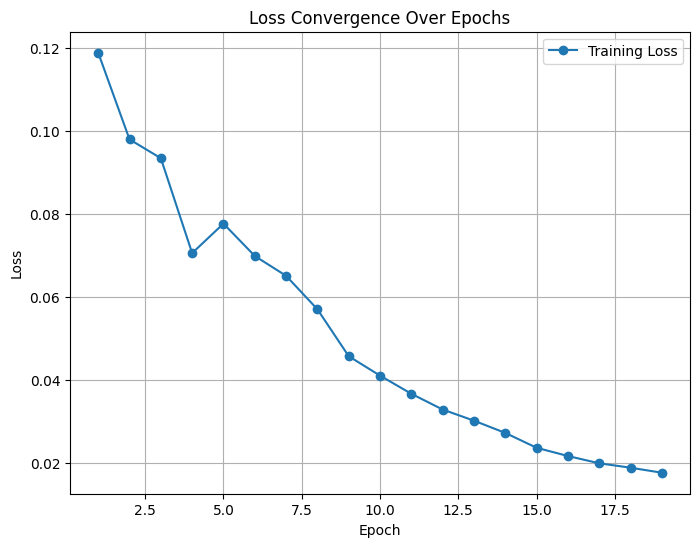

In [40]:
import matplotlib.pyplot as plt

# Plot the loss values
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs ), train_losses[:19], marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Convergence Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

In [41]:
# Evaluate model
model.eval()
with torch.no_grad():
    text_test_features = X_test_tensor[:, :512]
    image_test_features = X_test_tensor[:, 512:]
    test_outputs = model(text_test_features, image_test_features)
    test_predictions = torch.argmax(test_outputs, axis=1).cpu().numpy()  # Move predictions back to CPU for compatibility

# Metrics
print(classification_report(y_test, test_predictions,target_names=["1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"]))

              precision    recall  f1-score   support

      1 Star       0.22      0.25      0.24         8
     2 Stars       0.27      0.38      0.32         8
     3 Stars       0.35      0.35      0.35        20
     4 Stars       0.35      0.57      0.43        30
     5 Stars       0.82      0.57      0.67        74

    accuracy                           0.51       140
   macro avg       0.40      0.42      0.40       140
weighted avg       0.59      0.51      0.53       140



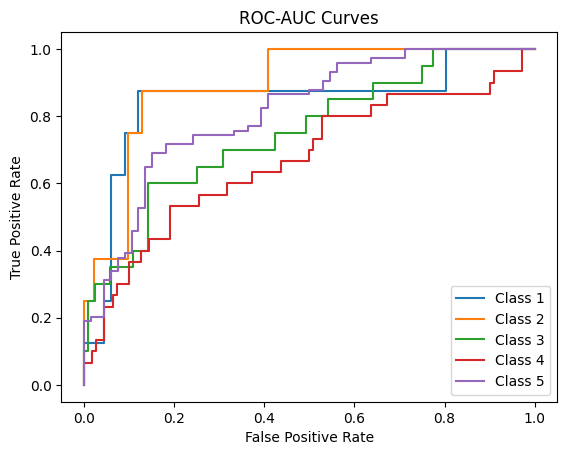

In [42]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, roc_curve

# ROC-AUC and Precision-Recall curves
y_test_onehot = np.eye(5)[y_test.astype(int)]  # Convert to one-hot for multi-class
test_probs = torch.softmax(test_outputs, axis=1).cpu().numpy()

# ROC-AUC
for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], test_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {i+1}")
plt.title("ROC-AUC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


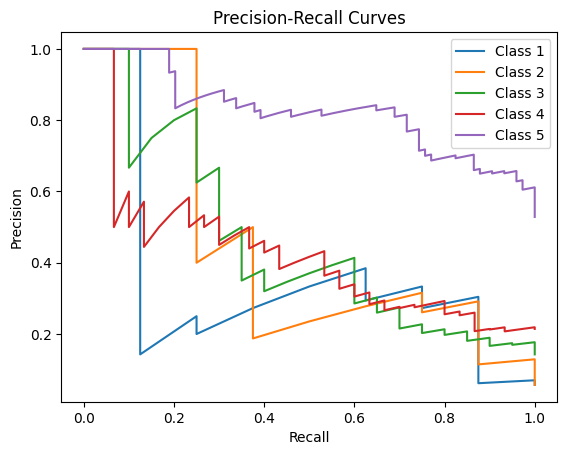

In [43]:
# Precision-Recall
for i in range(5):
    precision, recall, _ = precision_recall_curve(y_test_onehot[:, i], test_probs[:, i])
    plt.plot(recall, precision, label=f"Class {i+1}")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

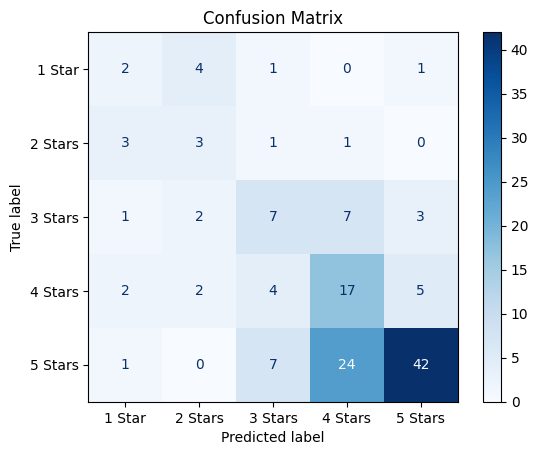

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"])
disp.plot(cmap=plt.cm.Blues, values_format="d")

# Add title and show the plot
plt.title("Confusion Matrix")
plt.show()
